In [1]:
import sys
sys.path.append('..')
import jackknife as jk

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Load Demo Dataset


In [2]:
tmp = pd.read_table("../data/demo-data-1.txt", delim_whitespace=True, header=None)
df = tmp[[4,7,8,15]]
df.columns=["pop", "phys", "beds", "income"]
df.head()

,pop,phys,beds,income
0,8863164,23677,27700,184230
1,5105067,15153,21550,110928
2,2818199,7553,12449,55003
3,2498016,5905,6179,48931
4,2410556,6062,6369,58818


## Specify the model/algorithm
Model/algorithm: Linear Regression, OLS, by solving linear equations and LU decomposition

In [3]:
def linreg_ols_lu(y, X):
    import numpy as np
    try:  # solve OLS formula
        return np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    except np.linalg.LinAlgError:
        print("LinAlgError: X*X' is singular or not square.")
        return None

Wrap `linreg_ols_lu` into a generic wrapper for `jk.jackknife`

In [4]:
def myfunc(data):
    return linreg_ols_lu( data[:,0], data[:,1:] );

## Example 1: phys vs beds

### Prep the data
Select `phys` as target variable, and use an intercept term (`1s`) and `beds` as design matrix.

In [5]:
y_train = df['phys'].values
X_train = np.c_[np.ones(shape=(len(y_train),)), df['beds'].values]

### Estimate all Delete-1 Jackknife subsamples

In [6]:
theta_subsample, theta_fullsample = jk.jk_loop(
    myfunc, np.c_[y_train, X_train], d=1)

### Check the estimated coefficients
The estimates for the full sample

In [7]:
print(theta_fullsample)

[-95.93218474   0.74311644]


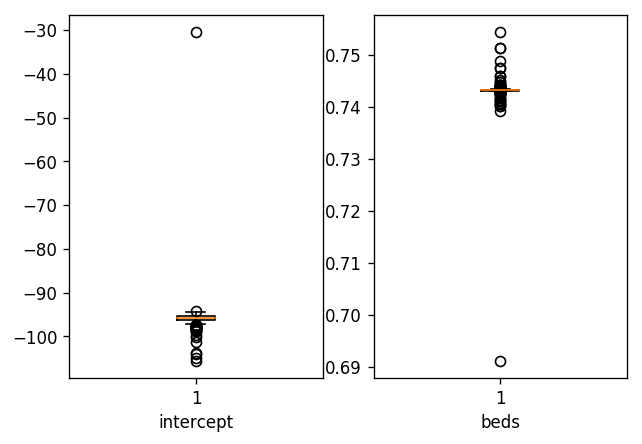

In [8]:
fig = plt.figure(dpi=120)
plt.subplot(121)
plt.boxplot(theta_subsample[:,0]);
plt.xlabel('intercept');
plt.subplot(122)
plt.boxplot(theta_subsample[:,1]);
plt.xlabel('beds');

## Jackknife Estimates

In [9]:
pvalues, tscores, theta_jack, se_jack, theta_biased = jk.jk_stats(
    theta_subsample, theta_fullsample)

The bias-corrected Jackknife estimates are

In [10]:
print(theta_jack)

[-112.8288585     0.75614251]


what is quite different from the OLS estimates for the whole sample

In [11]:
print(theta_fullsample)

[-95.93218474   0.74311644]


### Are the Jackknife Estimates significant?
No, the bias-corrected Jackknife estimates are not stable. 
The intercept has a p-value around 0.1 what is very far away from zero.

In [12]:
print(pvalues.round(3))

[0.107 0.   ]


### Print everything

In [13]:
jk.jk_print(
    pvalues, tscores, theta_jack, se_jack, theta_biased, theta_fullsample, 
    varnames=['intercept', 'beds'], N=len(y_train), d=1)


Delete-1 Jackknife, N=440
                                 intercept    beds    
                      p-Values:    0.10716    0.00000 
                      t-Scores:   -1.61439   13.49103 
 Jackknife Standard Error (SE):   69.88949    0.05605 
   Jackknife Estimates (theta): -112.829      0.756   
     Jackknife Biased Estimate:  -95.894      0.743   
          Full Sample Estimate:  -95.932      0.743   
